In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!cp /content/drive/MyDrive/Datasets/dataset.zip /content/

In [3]:
!unzip /content/dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: selected_train_audio/spoof/LA_T_2850612.flac  
  inflating: selected_train_audio/spoof/LA_T_1282219.flac  
  inflating: selected_train_audio/spoof/LA_T_4512688.flac  
  inflating: selected_train_audio/spoof/LA_T_2307693.flac  
  inflating: selected_train_audio/spoof/LA_T_3897361.flac  
  inflating: selected_train_audio/spoof/LA_T_1930732.flac  
  inflating: selected_train_audio/spoof/LA_T_3070376.flac  
  inflating: selected_train_audio/spoof/LA_T_1365409.flac  
  inflating: selected_train_audio/spoof/LA_T_4091103.flac  
  inflating: selected_train_audio/spoof/LA_T_2599425.flac  
  inflating: selected_train_audio/spoof/LA_T_3891659.flac  
  inflating: selected_train_audio/spoof/LA_T_4238059.flac  
  inflating: selected_train_audio/spoof/LA_T_4761800.flac  
  inflating: selected_train_audio/spoof/LA_T_1674369.flac  
  inflating: selected_train_audio/spoof/LA_T_3314176.flac  
  inflating: selected_train_audio/spoof/LA_T_1784

# Whisper Model For Deepfake Audio Detection


## How Whisper Processes Audio

1. Convert Audio to Spectrogram: The raw audio waveform is first converted into a log-Mel spectrogram representation, which is a common format in speech and audio processing. This spectrogram captures frequency and time information while being computationally efficient.

2. Spectrogram Specifications: Whisper uses a specific configuration for generating the Mel spectrogram:
    * Sample Rate: 16,000 Hz (Whisper expects audio to be resampled to 16 kHz if not already).
    * Window Size: 25 ms (400 samples at 16 kHz).
    * Hop Length: 10 ms (160 samples at 16 kHz).
    * Number of Mel Filters: 80.
    
      
3. Log-Mel Spectrogram Processing: Once the Mel spectrogram is generated, it is converted to a logarithmic scale, creating a log-Mel spectrogram. This transformation helps model the human perception of sound, as perceived loudness is logarithmic.

In [4]:
# Standard library imports
import os
import random

# Data processing and visualization imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Audio
from tqdm import tqdm

# PyTorch and audio processing imports
import torch
import torch.nn as nn
import torch.optim as optim
import torchaudio
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.tensorboard import SummaryWriter

# Hugging Face transformers imports
from transformers import WhisperFeatureExtractor, WhisperModel

# Evaluation metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Logging and experiment tracking
import wandb

## Data Visualization

> In the realm of deepfake audio detection, various audio features are instrumental in distinguishing between authentic and synthetic recordings. Among these, spectrograms, Mel spectrograms, and chroma features are particularly noteworthy.

### Spectograms
* Spectrograms provide a visual representation of an audio signal's frequency spectrum over time, capturing both temporal and spectral information. This dual representation is advantageous for detecting anomalies indicative of deepfake audio. For instance, certain synthesis methods may introduce artifacts or inconsistencies in the frequency domain, which become apparent when analyzing spectrograms. By examining these visual patterns, researchers can identify irregularities that suggest audio manipulation.
ARXIV

## Mel Spectograms
* Mel spectrograms are a variant of spectrograms that map frequencies onto the Mel scale, aligning more closely with human auditory perception. This perceptually motivated scaling emphasizes frequencies to which the human ear is more sensitive, thereby enhancing the detection of subtle artifacts introduced by deepfake generation techniques. Studies have demonstrated that Mel spectrograms, when used as input features for convolutional neural networks, improve the accuracy of deepfake audio detection systems.
ICTACT JOURNALS

## Chroma Features
* Chroma features capture the energy distribution across the twelve distinct pitch classes of the musical octave, effectively summarizing harmonic content. In the context of deepfake detection, chroma features are valuable for identifying inconsistencies in the harmonic structure of audio signals. Synthetic audio may exhibit unnatural harmonic patterns or deviations in pitch class distributions, which chroma analysis can reveal. Incorporating chroma features into detection frameworks has been shown to enhance the robustness of classifiers against various types of audio forgeries.
IEEE XPLORE

> Collectively, these features—spectrograms, Mel spectrograms, and chroma features—serve as critical tools in the detection of deepfake audio. By providing comprehensive insights into the spectral, perceptual, and harmonic characteristics of audio signals, they enable more effective identification of synthetic content.

In [5]:
# Visualization utility function
def visualize_audio_features(audio_file):
    """
    Visualizes various audio representations: waveform, spectrogram, Mel spectrogram, and chroma feature.

    Args:
        audio_file (str): Path to an audio file (.flac or other formats supported by torchaudio).
    """
    # Load the audio file
    audio, sample_rate = torchaudio.load(audio_file)

    # Convert to mono by averaging channels, if audio is stereo
    if audio.shape[0] > 1:
        audio = audio.mean(dim=0)

    # Normalize audio to ensure consistent visualization
    audio = audio / torch.max(torch.abs(audio))
    waveform_audio = audio.squeeze().numpy()  # Convert to numpy for plotting

    # Plot settings
    plt.figure(figsize=(15, 10))

    # Display the original waveform
    plt.subplot(2, 2, 1)
    plt.plot(waveform_audio, color='red')
    plt.title("Waveform")
    plt.xlabel("Samples")
    plt.ylabel("Amplitude")

    # Compute and display the spectrogram
    spectrogram = torchaudio.transforms.Spectrogram()(audio)
    plt.subplot(2, 2, 2)
    plt.imshow(spectrogram.log2().squeeze().detach().numpy(), cmap='viridis', origin='lower', aspect='auto')
    plt.colorbar(format="%+2.0f dB")
    plt.title("Spectrogram")
    plt.xlabel("Time")
    plt.ylabel("Frequency")

    # Compute and display the Mel spectrogram
    mel_spectrogram = torchaudio.transforms.MelSpectrogram(sample_rate=sample_rate)(audio)
    plt.subplot(2, 2, 3)
    plt.imshow(mel_spectrogram.log2().squeeze().detach().numpy(), cmap='viridis', origin='lower', aspect='auto')
    plt.colorbar(format="%+2.0f dB")
    plt.title("Mel Spectrogram")
    plt.xlabel("Time")
    plt.ylabel("Mel Frequency")

    # Compute and display the chroma feature using librosa
    try:
        import librosa
        import librosa.display
        # Convert audio to a numpy array for librosa processing
        audio_np = audio.numpy().flatten()
        mel_spectrogram_librosa = librosa.feature.melspectrogram(y=audio_np, sr=sample_rate)
        chroma = librosa.feature.chroma_stft(S=mel_spectrogram_librosa, sr=sample_rate)
        plt.subplot(2, 2, 4)
        librosa.display.specshow(chroma, x_axis='time', y_axis='chroma', cmap='coolwarm')
        plt.colorbar()
        plt.title("Chroma Feature")
        plt.xlabel("Time")
        plt.ylabel("Pitch Class")
    except ImportError:
        print("Librosa is required for chroma visualization. Install with `pip install librosa`.")

    # Adjust layout and display the plots
    plt.tight_layout()
    plt.show()

    # Play the audio
    print("Playing Audio:")
    display(Audio(audio.numpy(), rate=sample_rate))

/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


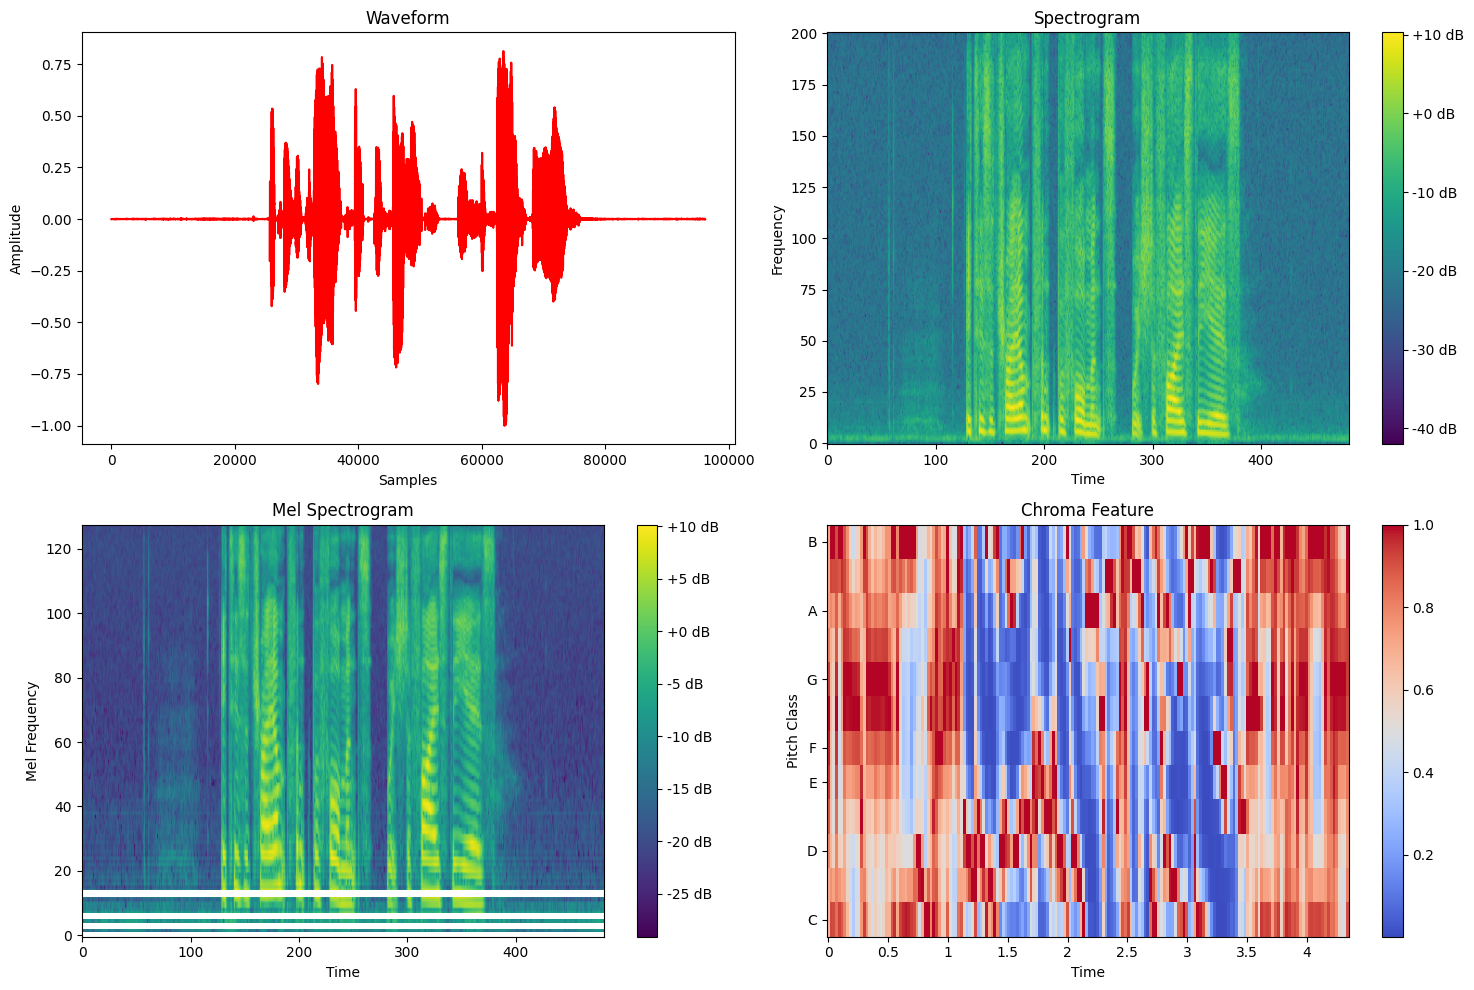

Playing Audio:


In [6]:
visualize_audio_features(audio_file="/content/selected_train_audio/bonafide/LA_T_1011221.flac")

/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


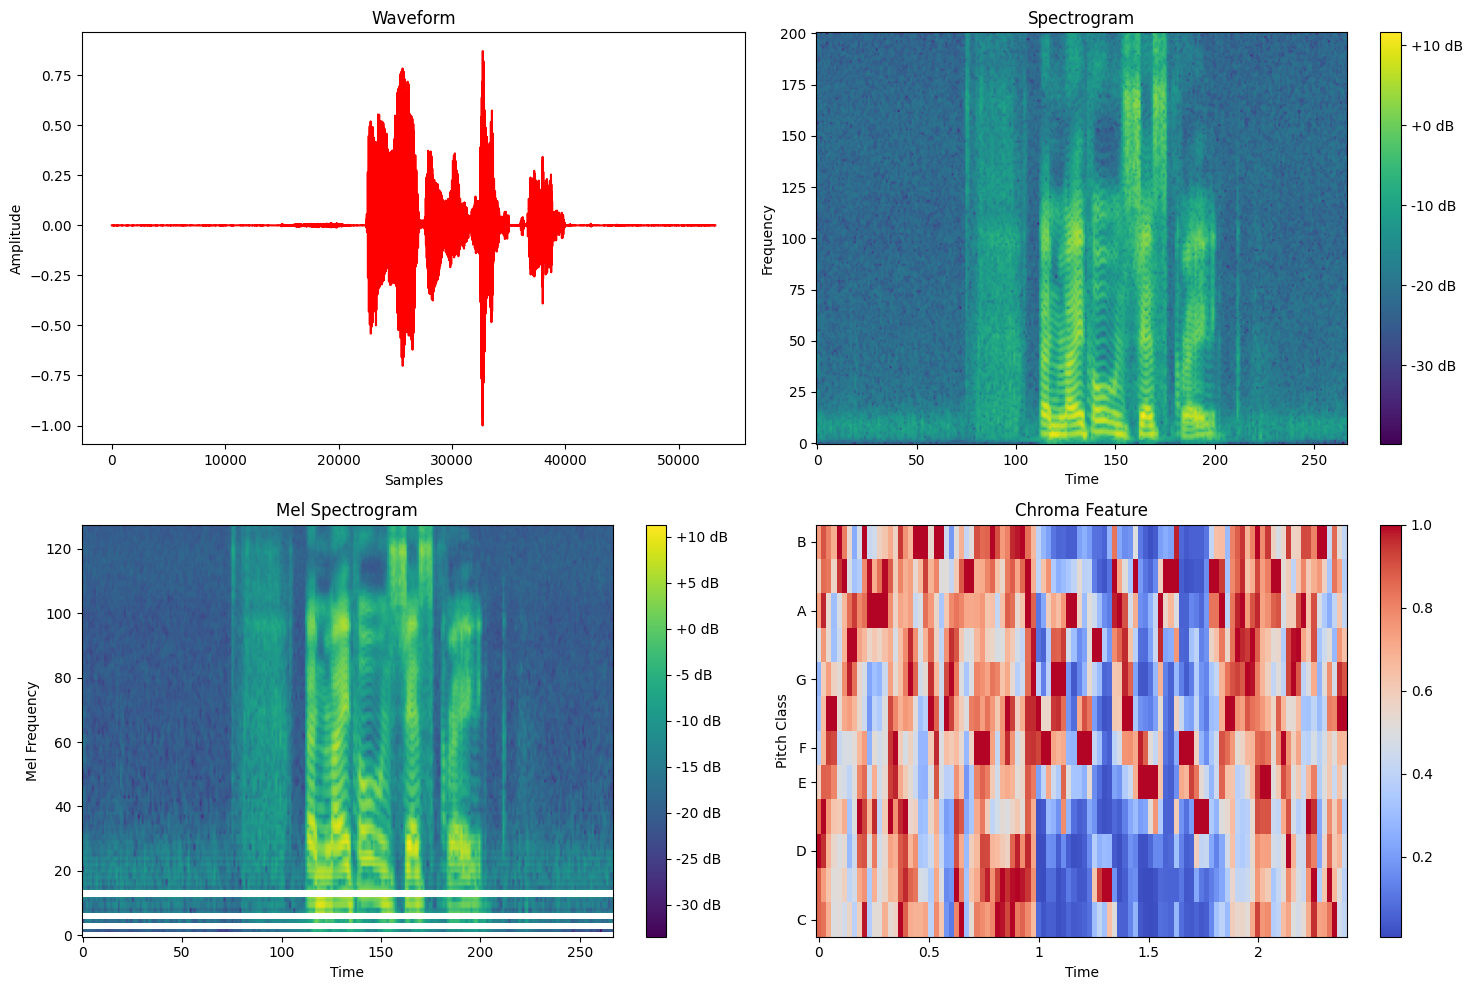

Playing Audio:


In [7]:
visualize_audio_features(audio_file="/content/selected_train_audio/spoof/LA_T_1001114.flac")

## Dataset Pipeline For Model Training

In [8]:
class ASVSpoof(Dataset):
    """
    Custom dataset class for loading and processing audio files and labels for the WhisperClassifier model.

    Args:
        base_dir (str): Base directory containing 'bonafide' and 'spoof' subdirectories.
        csv_file (str): Path to a CSV file with 'Filename' and 'Label' columns.
        feature_extractor: Pre-trained Whisper feature extractor.
        target_length (int): Target length in samples (e.g., 64000 for 4 seconds at 16 kHz).
        sample_rate (int): Target audio sample rate for resampling.
    """

    def __init__(self, base_dir, csv_file, feature_extractor, target_length=64000, sample_rate=16000):
        self.base_dir = base_dir
        self.feature_extractor = feature_extractor
        self.target_length = target_length
        self.sample_rate = sample_rate

        # Load the CSV file and map labels to integers (0 for 'bonafide' and 1 for 'spoof')
        self.data = pd.read_csv(csv_file)
        self.label_mapping = {"bonafide": 0, "spoof": 1}
        self.data['Label'] = self.data['Label'].map(self.label_mapping)

    def __len__(self):
        """
        Returns the total number of samples in the dataset.
        """
        return len(self.data)

    def __getitem__(self, idx):
        """
        Retrieves a single sample of audio data and its label.

        Args:
            idx (int): Index of the sample to retrieve.

        Returns:
            dict: Dictionary containing:
                  - 'input_features': Processed audio features ready for model input.
                  - 'labels': Integer label tensor for the audio sample.
        """
        # Retrieve the filename and label from the CSV file
        file_name = self.data.loc[idx, 'Filename']
        label = self.data.loc[idx, 'Label']

        # Determine the appropriate subdirectory based on the label
        subdir = "bonafide" if label == 0 else "spoof"
        file_path = os.path.join(self.base_dir, subdir, f"{file_name}.flac")

        # Load the audio file and retrieve its sample rate
        audio, original_sample_rate = torchaudio.load(file_path)

        # Resample the audio if its sample rate is different from the target sample rate
        if original_sample_rate != self.sample_rate:
            resampler = torchaudio.transforms.Resample(orig_freq=original_sample_rate, new_freq=self.sample_rate)
            audio = resampler(audio)

        # Convert to mono if the audio has multiple channels
        if audio.shape[0] > 1:
            audio = audio.mean(dim=0, keepdim=True)

        # Adjust the audio length to the target length by trimming or padding
        audio = self._trim_or_pad_audio(audio)

        # Convert the audio tensor to a numpy array for feature extraction
        audio_numpy = audio.squeeze().numpy()

        # Use the feature extractor to obtain Whisper-compatible input features
        inputs = self.feature_extractor(
            audio_numpy,
            sampling_rate=self.sample_rate,
            return_tensors="pt",
        )

        # Extract the input features and remove any extra dimensions
        input_features = inputs["input_features"].squeeze(0)  # Shape: (num_features, seq_len)

        return {
            "input_features": input_features,
            "labels": torch.tensor(label, dtype=torch.long)
        }

    def _trim_or_pad_audio(self, audio):
        """
        Pads or trims the audio tensor to match the target length.

        Args:
            audio (torch.Tensor): 1D tensor of audio samples.

        Returns:
            torch.Tensor: Audio tensor adjusted to `target_length` with a single channel dimension.
        """
        audio = audio.squeeze()  # Remove channel dimension if present
        current_length = audio.shape[-1]

        # Trim if audio is longer than target length
        if current_length > self.target_length:
            audio = audio[:self.target_length]
        # Pad with zeros if audio is shorter than target length
        elif current_length < self.target_length:
            padding = self.target_length - current_length
            audio = torch.nn.functional.pad(audio, (0, padding))

        return audio.unsqueeze(0)  # Add channel dimension back


In [9]:
# config.py

# Configuration settings for the ASVSpoof project


# BASE_DIRS = {
#     "train": "../dataset/dataset/selected_train_audio/",
#     "val": "../dataset/dataset/selected_val_audio/",
#     "test": "../dataset/dataset/selected_test_audio/"
# }

BASE_DIRS = {
    "train": "/content/selected_train_audio/",
    "val": "/content/selected_val_audio/",
    "test": "/content/selected_test_audio/"
}


# CSV_FILES = {
#     "train": "../dataset/dataset/train_balanced_dataframe.csv",
#     "val": "../dataset/dataset/val_dataframe.csv",
#     "test": "../dataset/dataset/test_dataframe.csv"
# }


CSV_FILES = {
    "train": "/content/train_balanced_dataframe.csv",
    "val": "/content/val_dataframe.csv",
    "test": "/content/test_dataframe.csv"
}

BASE_MODEL = "openai/whisper-base"
NUM_LABELS = 1

# Set batch size
BATCH_SIZE = 40

In [10]:
def create_dataloader(base_dir, csv_file, processor, batch_size=4, shuffle=True):
    """
    Creates an optimized DataLoader for the ASVSpoof dataset.

    Args:
        base_dir (str): Path to base directory containing audio files in 'bonafide' and 'spoof' subdirectories.
        csv_file (str): Path to CSV file with filenames and labels.
        processor (Wav2Vec2Processor): Processor for audio data.
        batch_size (int): Number of samples per batch.
        shuffle (bool): Whether to shuffle data.
        num_workers (int): Number of subprocesses to use for data loading.
        pin_memory (bool): Whether to use pinned memory for faster data transfer to GPU.

    Returns:
        DataLoader: Configured DataLoader for the dataset.
    """
    dataset = ASVSpoof(base_dir, csv_file, processor)
    return DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        collate_fn=collate_fn
    )


def collate_fn(batch):
    """
    Custom collate function for batching data with different audio lengths.
    """

    return {
        "input_values": torch.stack([item["input_features"] for item in batch]),
        "labels": torch.stack([item['labels'] for item in batch]),
    }

## Model Definition Whisper For Deepfake Detection

In [11]:
# Define WhisperClassifier for audio classification (encoder-only approach)
class WhisperClassifier(nn.Module):
    def __init__(self, model_name: str, num_labels: int):
        super(WhisperClassifier, self).__init__()
        # Load Whisper model without the generation head
        self.whisper_model = WhisperModel.from_pretrained(model_name)

        # Freeze Whisper model parameters to prevent updates during training
        for param in self.whisper_model.parameters():
            param.requires_grad = False

        # Hidden size of the Whisper model
        hidden_size = self.whisper_model.config.d_model

        # Classification head
        self.classifier = nn.Linear(hidden_size, num_labels)

    def forward(self, input_features):
        # Pass inputs through the Whisper encoder to get hidden states
        outputs = self.whisper_model.encoder(input_features)
        last_hidden_state = outputs.last_hidden_state  # shape (batch_size, seq_len, hidden_size)

        # Pool the outputs (e.g., take the mean over the sequence length)
        pooled_output = last_hidden_state.mean(dim=1)  # shape (batch_size, hidden_size)

        # Pass through the classifier
        logits = self.classifier(pooled_output)

        return logits

In [12]:
# Defining dataloader and model for training purpose

model = WhisperClassifier(model_name = BASE_MODEL, num_labels = NUM_LABELS)
processor = WhisperFeatureExtractor.from_pretrained(pretrained_model_name_or_path = BASE_MODEL)

train_loader = create_dataloader(BASE_DIRS["train"], CSV_FILES["train"], processor, batch_size=BATCH_SIZE)
val_loader = create_dataloader(BASE_DIRS["val"], CSV_FILES["val"], processor, batch_size=BATCH_SIZE)
test_loader = create_dataloader(BASE_DIRS["test"], CSV_FILES["test"], processor, batch_size=BATCH_SIZE)


# Example of accessing data from train_loader
for batch in train_loader:
    print(batch["input_values"].shape)
    print(batch["labels"].shape)
    break  # Print the shape of one batch and exit


# Example of accessing data from val_loader
for batch in val_loader:
    print(batch["input_values"].shape)
    print(batch["labels"].shape)
    break  # Print the shape of one batch and exit


# Example of accessing data from test_loader
for batch in test_loader:
    print(batch["input_values"].shape)
    print(batch["labels"].shape)
    break  # Print the shape of one batch and exit

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.98k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/290M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/185k [00:00<?, ?B/s]

torch.Size([40, 80, 3000])
torch.Size([40])
torch.Size([40, 80, 3000])
torch.Size([40])
torch.Size([40, 80, 3000])
torch.Size([40])


In [ ]:
# Calculating forward and backward pass memory
# Total memory used by model parameters (in bytes)
from torchinfo import summary

# Assuming `model` is your PyTorch model
batch_size = 10  # Or the batch size you'd like to simulate
input_shape = (10, 80, 3000)  # Replace `input_shape` with your model's input dimensions

# Print the model summary
summary(model, input_size=input_shape, col_names=["input_size", "output_size", "num_params", "params_percent"])

Layer (type:depth-idx)                                  Input Shape               Output Shape              Param #                   Param %
WhisperClassifier                                       [10, 80, 3000]            [10, 1]                   --                             --
├─WhisperModel: 1-1                                     --                        --                        52,003,328                 71.64%
│    └─WhisperEncoder: 2-1                              [10, 80, 3000]            [10, 1500, 512]           768,000                     1.06%
│    │    └─Conv1d: 3-1                                 [10, 80, 3000]            [10, 512, 3000]           (123,392)                   0.17%
│    │    └─Conv1d: 3-2                                 [10, 512, 3000]           [10, 512, 1500]           (786,944)                   1.08%
│    │    └─ModuleList: 3-3                             --                        --                        (18,911,232)               26.05%
│    │

In [13]:
if  os.path.exists("./Whisper") == False:
    os.mkdir("./Whisper")
import wandb

## Trainig loop for final training

In [14]:
# This code is adapted from Homework 1 and changed to accomododate Whisper Training

# Common settings and constants
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-2
GAMMA = 0.9  # Decay factor for the exponential scheduler
NUM_EPOCHS = 20
ACCUMULATION_STEPS = 4
CHECKPOINT_PATH = "./Whisper/Whisper_checkpoint.pth"
DEVICE = "cuda"

# Enable cuDNN benchmarking for faster computation on compatible architectures
torch.backends.cudnn.benchmark = True

# Initialize Weights and Biases (wandb) logging
wandb.init(project="audio-classification", name="Whisper Deepfake Detection")

model = model.to(DEVICE)

# Define optimizer, scheduler, and loss function
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=GAMMA)
criterion = nn.BCEWithLogitsLoss()  # Binary classification loss function

# Mixed precision scaler
scaler = torch.amp.GradScaler("cuda")

# Lists to keep track of training and validation losses
train_losses = []
val_losses = []

# Function to load checkpoint
def load_checkpoint(checkpoint_path, model, optimizer, scheduler):
    if os.path.isfile(checkpoint_path):
        print(f"Loading checkpoint from {checkpoint_path}")
        checkpoint = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        start_epoch = checkpoint['epoch']
        best_val_loss = checkpoint['best_val_acc']

        print(f"Resuming training from epoch {start_epoch+1} with best validation accuracy {best_val_loss:.4f}")
        return start_epoch, best_val_loss
    else:
        print("No checkpoint found. Starting training from scratch.")
        return 0, float('inf')

# Load checkpoint if available
start_epoch, best_val_loss = load_checkpoint(CHECKPOINT_PATH, model, optimizer, scheduler)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


No checkpoint found. Starting training from scratch.


In [16]:
# Training and Validation function
def train_and_validate(model, criterion, optimizer, scheduler, num_epochs=NUM_EPOCHS, start_epoch=0, best_val_acc=0):
    for epoch in range(start_epoch, num_epochs):
        # Training phase
        model.train()
        print("Model is running on:", next(model.parameters()).device)

        running_loss = 0.0
        correct = 0
        total = 0

        # Improve DataLoader efficiency
        train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Training]", leave=False)

        optimizer.zero_grad()  # Reset gradients before each epoch
        for i, batch in enumerate(train_bar):
            inputs = batch["input_values"].to(DEVICE, non_blocking=True)
            labels = batch["labels"].to(DEVICE, non_blocking=True).float()  # Convert labels to float

            # Mixed precision training with autocast
            with torch.amp.autocast("cuda"):
                # Forward pass
                outputs = model(inputs)
                outputs = outputs.squeeze()  # Ensuring outputs have shape [batch_size]
                loss = criterion(outputs, labels)
                loss = loss / ACCUMULATION_STEPS  # Scale the loss for accumulation

            # Backward pass
            scaler.scale(loss).backward()

            # Update weights and zero gradients after ACCUMULATION_STEPS iterations

            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

            # Track metrics efficiently with vectorized operations
            running_loss += loss.detach() * inputs.size(0) * ACCUMULATION_STEPS
            predicted = (outputs > 0).long()  # Use threshold of 0 for binary classification
            total += labels.size(0)
            correct += (predicted == labels.long()).sum().item()

        # Calculate training loss and accuracy
        epoch_train_loss = running_loss.item() / len(train_loader.dataset)
        epoch_train_acc = 100 * correct / total
        train_losses.append(epoch_train_loss)

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            val_bar = tqdm(val_loader, desc="Validation", leave=False)
            for batch in val_bar:
                inputs = batch["input_values"].to(DEVICE, non_blocking=True)
                labels = batch["labels"].to(DEVICE, non_blocking=True).float()  # Convert labels to float

                # Mixed precision training with autocast
                with torch.amp.autocast("cuda"):
                    # Forward pass
                    outputs = model(inputs)
                    outputs = outputs.squeeze()  # Ensuring outputs have shape [batch_size]
                    loss = criterion(outputs, labels)

                # Track validation metrics efficiently
                val_loss += loss.item() * inputs.size(0)
                predicted = (outputs > 0).long()  # Use threshold of 0 for binary classification
                val_total += labels.size(0)
                val_correct += (predicted == labels.long()).sum().item()

        # Calculate validation loss and accuracy
        epoch_val_loss = val_loss / len(val_loader.dataset)
        epoch_val_acc = 100 * val_correct / val_total
        val_losses.append(epoch_val_loss)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.2f}%, "
              f"Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.2f}%")

        # Logging to wandb
        wandb.log({
            'epoch': epoch + 1,
            'train_loss': epoch_train_loss,
            'train_accuracy': epoch_train_acc,
            'val_loss': epoch_val_loss,
            'val_accuracy': epoch_val_acc
        })

        # Save model if it has the best validation accuracy
        if epoch_val_acc > best_val_acc:
            best_val_acc = epoch_val_acc
            model_save_path = f"./Whisper/Whisper_best_val_acc_{best_val_acc:.2f}.pth"
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'best_val_acc': best_val_acc
            }, model_save_path)
            print(f"New best model saved with validation accuracy {best_val_acc:.2f}% at epoch {epoch + 1}")

        # Step the scheduler
        scheduler.step()


# Run training and validation
train_and_validate(model, criterion, optimizer, scheduler, num_epochs=NUM_EPOCHS, start_epoch=start_epoch, best_val_acc=0)

# End WandB session if using wandb
wandb.finish()

Model is running on: cuda:0


Epoch 1/20, Train Loss: 0.6025, Train Acc: 73.45%, Val Loss: 0.5396, Val Acc: 82.90%
New best model saved with validation accuracy 82.90% at epoch 1
Model is running on: cuda:0


Epoch 2/20, Train Loss: 0.5108, Train Acc: 83.70%, Val Loss: 0.4685, Val Acc: 87.80%
New best model saved with validation accuracy 87.80% at epoch 2
Model is running on: cuda:0


Epoch 3/20, Train Loss: 0.4604, Train Acc: 85.54%, Val Loss: 0.4279, Val Acc: 89.10%
New best model saved with validation accuracy 89.10% at epoch 3
Model is running on: cuda:0


Epoch 4/20, Train Loss: 0.4273, Train Acc: 86.43%, Val Loss: 0.3989, Val Acc: 89.50%
New best model saved with validation accuracy 89.50% at epoch 4
Model is running on: cuda:0


Epoch 5/20, Train Loss: 0.4021, Train Acc: 87.33%, Val Loss: 0.3815, Val Acc: 88.10%
Model is running on: cuda:0


Epoch 6/20, Train Loss: 0.3834, Train Acc: 88.14%, Val Loss: 0.3633, Val Acc: 89.50%
Model is running on: cuda:0


Epoch 7/20, Train Loss: 0.3678, Train Acc: 88.95%, Val Loss: 0.3492, Val Acc: 90.00%
New best model saved with validation accuracy 90.00% at epoch 7
Model is running on: cuda:0


Epoch 8/20, Train Loss: 0.3550, Train Acc: 89.53%, Val Loss: 0.3386, Val Acc: 90.50%
New best model saved with validation accuracy 90.50% at epoch 8
Model is running on: cuda:0


Epoch 9/20, Train Loss: 0.3445, Train Acc: 89.88%, Val Loss: 0.3299, Val Acc: 91.00%
New best model saved with validation accuracy 91.00% at epoch 9
Model is running on: cuda:0


Epoch 10/20, Train Loss: 0.3357, Train Acc: 90.21%, Val Loss: 0.3218, Val Acc: 91.10%
New best model saved with validation accuracy 91.10% at epoch 10
Model is running on: cuda:0


Epoch 11/20, Train Loss: 0.3282, Train Acc: 90.39%, Val Loss: 0.3196, Val Acc: 92.10%
New best model saved with validation accuracy 92.10% at epoch 11
Model is running on: cuda:0


Epoch 12/20, Train Loss: 0.3217, Train Acc: 90.60%, Val Loss: 0.3119, Val Acc: 92.10%
Model is running on: cuda:0


Epoch 13/20, Train Loss: 0.3164, Train Acc: 90.68%, Val Loss: 0.3049, Val Acc: 91.70%
Model is running on: cuda:0


Epoch 14/20, Train Loss: 0.3111, Train Acc: 91.03%, Val Loss: 0.3016, Val Acc: 91.30%
Model is running on: cuda:0


Epoch 15/20, Train Loss: 0.3077, Train Acc: 91.30%, Val Loss: 0.2971, Val Acc: 91.80%
Model is running on: cuda:0


Epoch 16/20, Train Loss: 0.3034, Train Acc: 91.18%, Val Loss: 0.2937, Val Acc: 92.20%
New best model saved with validation accuracy 92.20% at epoch 16
Model is running on: cuda:0


Epoch 17/20, Train Loss: 0.3000, Train Acc: 91.36%, Val Loss: 0.2919, Val Acc: 92.90%
New best model saved with validation accuracy 92.90% at epoch 17
Model is running on: cuda:0


Epoch 18/20, Train Loss: 0.2974, Train Acc: 91.51%, Val Loss: 0.2900, Val Acc: 92.60%
Model is running on: cuda:0


Epoch 19/20, Train Loss: 0.2944, Train Acc: 91.59%, Val Loss: 0.2864, Val Acc: 92.50%
Model is running on: cuda:0


Epoch 20/20, Train Loss: 0.2921, Train Acc: 91.65%, Val Loss: 0.2853, Val Acc: 93.00%
New best model saved with validation accuracy 93.00% at epoch 20


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_accuracy,▁▅▆▆▆▇▇▇▇▇██████████
train_loss,█▆▅▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁
val_accuracy,▁▄▅▆▅▆▆▆▇▇▇▇▇▇▇▇████
val_loss,█▆▅▄▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁
epoch,20
train_accuracy,91.64729
train_loss,0.29206
val_accuracy,93
val_loss,0.28526


## Evaluating the Model on Test Dataset

In [17]:
# Define the device
device = "cuda" if torch.cuda.is_available() else "cpu"

# Instantiate the WhisperClassifier model
model = WhisperClassifier(model_name=BASE_MODEL, num_labels=NUM_LABELS)  # Adjust model_name and num_labels as needed
model = model.to(device)

# Load the checkpoint (replace with the actual checkpoint path if needed)
checkpoint_path = "/content/Whisper/Whisper_best_val_acc_93.00.pth"
checkpoint = torch.load(checkpoint_path, map_location=device)

print("loading saved model")
start_epoch, best_val_loss = load_checkpoint(checkpoint_path, model, optimizer, scheduler)

checkpoint

# Set the model to evaluation mode
model.eval()

import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tqdm import tqdm

def evaluate_model(model, test_loader):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        test_bar = tqdm(test_loader, desc="Testing", leave=False)
        for batch in test_bar:
            # Extract input features and labels from the batch dictionary
            input_features = batch["input_values"].to(device)  # Corrected to match your dictionary key
            labels = batch["labels"]

            # Forward pass
            logits = model(input_features).squeeze()  # Remove extra dimensions if present

            # Apply sigmoid to get probabilities
            probs = torch.sigmoid(logits)

            # Classify based on a 0.5 threshold
            predicted = (probs > 0.5).long()

            # Store predictions and labels for metrics calculation
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    # Print and log the metrics
    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    # Optional: return metrics for further analysis
    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1
    }

# Run the evaluation
test_metrics = evaluate_model(model, test_loader)

<ipython-input-17-0e027a7a2fa0>:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)


loading saved model
Loading checkpoint from /content/Whisper/Whisper_best_val_acc_93.00.pth


<ipython-input-14-ffb2802c88df>:36: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


Resuming training from epoch 21 with best validation accuracy 93.0000


Test Accuracy: 0.9140
Precision: 0.9304
Recall: 0.8950
F1 Score: 0.9123


In [18]:
import pandas as pd
metrics_df = pd.DataFrame(test_metrics, index=[0])
metrics_df.to_csv("/content/Whisper/test_metrics.csv", index=False)